In [398]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rand
import pickle as pkl
import warnings
import statsmodels.tools as stm
import statsmodels.api as stmapi

yt=pd.read_csv(r'C:\Users\Varishu Pant\Desktop\Praxis docs\Excel\YtDataOld.csv')  #Reading Data

In [2]:
def pipeline(data):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import random as rand
    import pickle as pkl
    import warnings
    warnings.filterwarnings('ignore')
    to_remove=['Unnamed: 0','Unnamed: 0.1','twitter_url','defaultAudioLanguage']  #Removing Unncessary Columns
    data=data.drop(to_remove,axis=1)
   

    weekdays=['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']
    categories=['Film & Animation','Autos & Vehicles','Music','Pets & Animals','Sports','Travel & Events','Gaming','People & Blogs','Comedy','Entertainment','News & Politics','Howto & Style','Education','Science & Technology','Nonprofits & Activism']

    for i in range(0,7):
        data.day_uploaded[data.day_uploaded==i]=weekdays[i]
    for i in range(0,15):
        data.categoryId[data.categoryId==i]=categories[i]

    data['YearPublished']=0
    years=[2010,2011,2012,2013,2014,2015,2016]
    for i in range(0,7):
        data['YearPublished'][data[(data['months_old']>12*i) & (data['months_old']<=12*(i+1))].index]=years[i]
    
    data=data.drop(index=data[data['YearPublished']==0].index,axis=0)
    
    data=data.drop(index=data[data['duration']==0].index,axis=0)
    return(data)


In [3]:
rand.seed(0)                                                                          #Setting seed for reproducble results
train_indices=np.random.choice(yt.index, round(0.9*len(yt.index)), replace=False)     #Train-Test Split(90-10)
yt_train=yt.iloc[train_indices,:]
yt_train=pipeline(yt_train)

In [4]:
yt_train.shape

(312821, 34)

### Video Frequency Distribution

In [9]:
yt_train['day_uploaded'].value_counts()  #Checking if data collection was unbiased towards 'day_uploaded'

Tuesday      51512
Friday       50875
Thursday     50511
Wednesday    50468
Monday       47844
Saturday     31376
Sunday       30236
Name: day_uploaded, dtype: int64

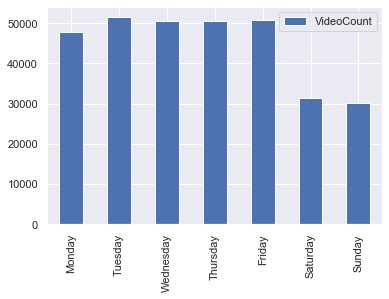

In [12]:
vids_per_day=pd.DataFrame(yt_train['day_uploaded'].value_counts())
reorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
vids_per_day=vids_per_day.reindex(labels=reorder)
vids_per_day.rename(columns={'day_uploaded':'VideoCount'},inplace=True)
sns.set()
vids_per_day.plot(kind='bar')
plt.show()

We see that on average we have 50000 videos for each day of the week except for weekends which average around 30000.The reason for the variance in the frequency distribution is because during collection of data through web scraping,for each month,videos were gathered using random sampling. Hence, we can interpret that in general,less number of videos are uploaded during Saturday and Sunday.

In [41]:
ct=pd.crosstab(yt_train.day_uploaded,yt_train.categoryId).apply(lambda r: r/r.sum()*100, axis=0)
reorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ct=ct.reindex(labels=reorder)
ct

categoryId,Autos & Vehicles,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events
day_uploaded,,,,,,,,,,,,,,,
Monday,15.758780,13.887178,16.358590,15.074421,13.943906,13.183017,14.850542,16.613657,14.897804,17.723151,15.104282,15.480982,15.653468,15.838078,15.357679
Tuesday,16.938097,16.074100,17.685262,15.283656,16.884394,15.305937,15.654400,17.731836,16.592871,18.436680,15.679936,15.546388,17.362310,16.183261,15.898859
Wednesday,15.849497,16.245710,16.758257,16.058776,16.280376,14.210383,15.553174,16.091840,17.321884,16.834691,15.759642,16.019320,17.136052,15.344959,16.753831
Thursday,15.568707,16.377717,17.635304,16.073042,17.610151,14.924084,15.743718,15.977537,17.089315,17.778392,14.338219,15.018112,17.755284,15.748420,15.116649
Friday,16.458594,17.292968,16.230919,17.295164,16.743925,15.142286,15.868763,18.671106,16.642068,16.139576,15.772927,16.220568,15.582018,15.237369,14.625495
Saturday,9.050067,10.556191,7.504857,10.884968,9.935852,14.410401,11.373109,7.867011,9.320632,6.628919,12.031174,10.776816,8.258410,10.597570,10.559825
Sunday,10.376258,9.566136,7.826811,9.329973,8.601395,12.823893,10.956294,7.047013,8.135426,6.458592,11.313820,10.937814,8.252456,11.050343,11.687662


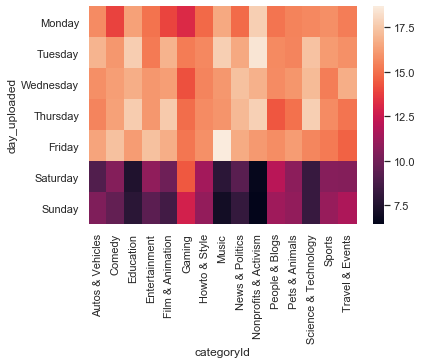

In [43]:
sns.heatmap(ct)
plt.show()

In general,for each category, less number of videos are being uploaded on weekends.At one extreme,we have 'Gaming' where all week through,approximately equal number of videos are being uploaded.On the other extreme,for 'Music' we have a huge drop in videos uploaded on weekends.

#### Why is this divide present?

Checking top5 contributors for music-

In [302]:
music=yt_train[yt_train['categoryId']=='Music']
top5_music=music[['viewCount','channelId']].groupby('channelId').count().sort_values(by='viewCount',ascending=False).head(5)
top5_music

,viewCount
channelId,
UCq-Fj5jknLsUf-MWSy4_brA,379
UCweOkPb1wVVH0Q0Tlj4a5Pw,199
UCpDJl2EmP7Oh90Vylx0dZtA,139
UC3I2GFN_F8WudD_2jUZbojA,135
UC-FQUIVQ-bZiefzBiQAa8Fw,113


1.Tseries

2.1theK (원더케이)

3.Spinnin' Records 

4.KEXP

5.BBC Radio 1 


All these channels are run by record labels and music production companies that aim at making profit by marketing their videos on the platform.

In [395]:
total_music=music['V_id'].count()         
tseries=yt_train[yt_train['channelId']=='UCq-Fj5jknLsUf-MWSy4_brA']
one_thek=yt_train[yt_train['channelId']=='UCweOkPb1wVVH0Q0Tlj4a5Pw']
spinnin_records=yt_train[yt_train['channelId']=='UCpDJl2EmP7Oh90Vylx0dZtA']
kexp=yt_train[yt_train['channelId']=='UC3I2GFN_F8WudD_2jUZbojA']
bbcradio1=yt_train[yt_train['channelId']=='UC-FQUIVQ-bZiefzBiQAa8Fw']

In [370]:
def plot_relative_freq(data):
    data_vids_per_day=pd.DataFrame(data['day_uploaded'].value_counts()/data['day_uploaded'].value_counts().sum()*100)
    reorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    data_vids_per_day=data_vids_per_day.reindex(labels=reorder)
    plt.plot(data_vids_per_day)
    plt.title('Relative Frequency of Uploads')
    plt.ylabel('Percentage')
    plt.xticks(rotation=30)

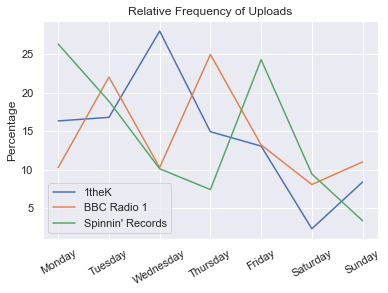

In [393]:
plot_relative_freq(one_thek)
plot_relative_freq(bbcradio1)
plot_relative_freq(spinnin_records)

plt.legend(labels=['1theK', 'BBC Radio 1','Spinnin\' Records'])
plt.show()

These record labels tend to upload more frequently on a particular day of the week.For example,1thek uploads most videos on Wednesday while BBC Radio 1 prefers Tuesday and Thursday.Simialrly,Spinnin' Records upload mostly on Monday and Friday.Neither like uploading on the weekends.

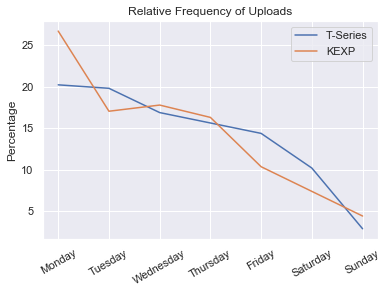

In [394]:
plot_relative_freq(tseries)
plot_relative_freq(kexp)

plt.legend(labels=['T-Series', 'KEXP'])
plt.show()

These channels upload the most at the starting of the week(Monday).We notice a gradual decrease in the frequency of uploads as week progresses.As seen before,frequency of uploads is the lowest during weekends.

Checking top5 contributors for gaming-

In [332]:
gaming=yt_train[yt_train['categoryId']=='Gaming']
top5_gaming=gaming[['viewCount','channelId']].groupby('channelId').count().sort_values(by='viewCount',ascending=False).head(5)
top5_gaming

,viewCount
channelId,
UC-lHJZR3Gqxm24_Vd_AJ5Yw,964
UCpGdL9Sn3Q5YWUH2DVUW1Ug,565
UCS5Oz6CHmeoF7vSad0qqXfw,544
UC7_YxT-KID8kRbqZo7MyscQ,532
UCYzPXprvl5Y-Sf0g4vX-m6g,478


1.PewDiePie

2.PopularMMOs

3.Markiplier

4.DanTDM


5.jacksepticeye 


All these channels are run by Youtubers that are essentially people that started out as users of Youtube and eventually began uploading their own videos.Their channels stood the test of time and they grew as Youtube grew in popularity.

In [396]:
pewdie=yt_train[yt_train['channelId']=='UC-lHJZR3Gqxm24_Vd_AJ5Yw']
popmmos=yt_train[yt_train['channelId']=='UCpGdL9Sn3Q5YWUH2DVUW1Ug']
mark=yt_train[yt_train['channelId']=='UC7_YxT-KID8kRbqZo7MyscQ']
dan=yt_train[yt_train['channelId']=='UCS5Oz6CHmeoF7vSad0qqXfw']
jack=yt_train[yt_train['channelId']=='UCYzPXprvl5Y-Sf0g4vX-m6g']


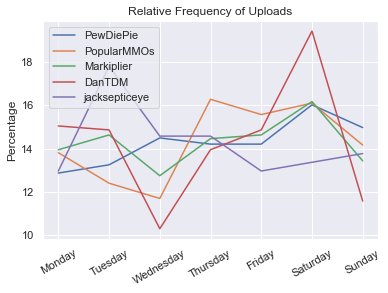

In [397]:
plot_relative_freq(pewdie)
plot_relative_freq(popmmos)
plot_relative_freq(mark)
plot_relative_freq(dan)
plot_relative_freq(jack)


plt.legend(labels=['PewDiePie', 'PopularMMOs', 'Markiplier','DanTDM','jacksepticeye'])
plt.show()

There is no general trend unlike music videos.

Observation-We can say that since most contributors for Music are corporations ,they plan their video uploads and avoid weekends,as record labels have weekends as holidays.Gaming,on the other hand has mostly individuals or a group of individuals that have made Youtube as a viable career and work on uploading regularly.They may be partial to a particular day depending on how well they understand their audience but there is no apparent reason for them to avoid uploading on weekends.

In [368]:
yt_train['categoryId'].value_counts()  #Fairly proportionate distribution of number of videos per category

Autos & Vehicles         23138
Comedy                   22747
People & Blogs           22537
News & Politics          22372
Sports                   22352
Gaming                   21971
Travel & Events          21955
Nonprofits & Activism    21781
Film & Animation         21356
Entertainment            21070
Music                    20120
Pets & Animals           19899
Education                18002
Howto & Style            16774
Science & Technology     16747
Name: categoryId, dtype: int64

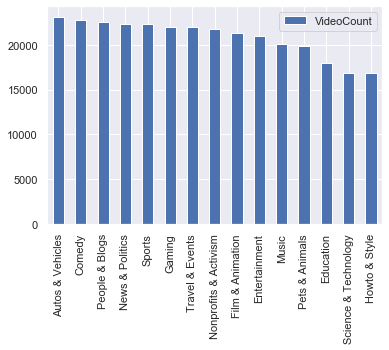

In [47]:
vids_per_category=pd.DataFrame(yt_train['categoryId'].value_counts())
vids_per_category.rename(columns={'categoryId':'VideoCount'},inplace=True)
sns.set()
vids_per_category.plot(kind='bar')
plt.show()

Fairly proportionate distribution of videos uploaded among categories.

In [219]:
yt_train['viewCount'].describe().apply(lambda x: format(x, 'f'))  #Describing Target Variable

count        312822.000000
mean        2357673.607444
std        19037877.713902
min               0.000000
25%           52874.000000
50%          242669.000000
75%         1101009.250000
max      2110166091.000000
Name: viewCount, dtype: object

### Outlier Analysis

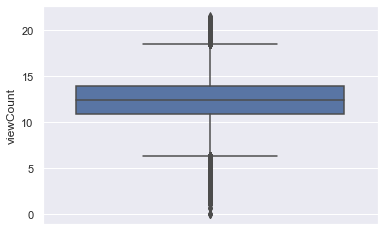

No. of Outliers= 43390
Percentage of Outliers= 13.87


In [246]:
sns.boxplot(data=yt_train,y=log_Y)              
plt.show()
iqr=np.quantile(yt_train.viewCount,0.75)-np.quantile(yt_train.viewCount,0.25)  #InterQuartile Range
up=np.quantile(yt_train.viewCount,0.75)+1.5*iqr                                 
lw=np.quantile(yt_train.viewCount,0.25)-1.5*iqr
outliersNo=len(yt_train.viewCount[yt_train.viewCount>up])+len(yt_train.viewCount[yt_train.viewCount<lw])
print('No. of Outliers=',outliersNo)
print('Percentage of Outliers=',round(outliersNo/len(yt_train.viewCount)*100,2))


### Bivariate Analysis

In [357]:
cat_vars=['V_id','caption','categoryId','channelId','definition','dimension','embeddable','licencedContent','license','privacyStatus','projection','thumbnail','day_uploaded','YearPublished']
data_num=yt_train.drop(cat_vars,axis=1)
nominal=['thumbnail', 'V_id', 'channelId']
num_vars = [x for x in yt_train.columns if x not in cat_vars]
ordinal=[x for x in cat_vars if x not in nominal]

In [358]:
data_num.corr()['viewCount'][num_vars]  #commentCount,dislikeCount,likeCount

commentCount                  0.605396
dislikeCount                  0.812544
duration                     -0.020668
likeCount                     0.844015
viewCount                     1.000000
channel_ViewCount             0.115825
channel_commentCount          0.023535
channel_subscriberCount       0.101381
channel_videoCount           -0.028352
description_length            0.002733
http_in_descp                 0.045400
tags_in_desc                  0.015743
video_title_length            0.002403
tags_in_title                 0.015743
No_of_tags                    0.015082
channel_title_length         -0.026164
channel_description_length   -0.035994
months_old                   -0.017012
channel_months_old           -0.016157
social_links                  0.029414
Name: viewCount, dtype: float64

#### How is like,dislike and comment count related to view count?

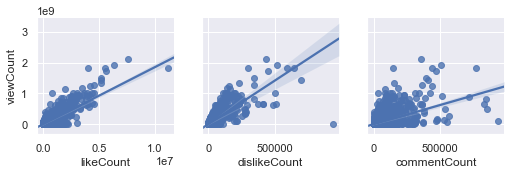

In [272]:
sns.pairplot(data=yt_train,y_vars=['viewCount'],x_vars=['likeCount','dislikeCount','commentCount'],kind='reg')
plt.show()

All 3 variables are highly positively correlated with viewCount which is common sense.

### How does Category affect Views?


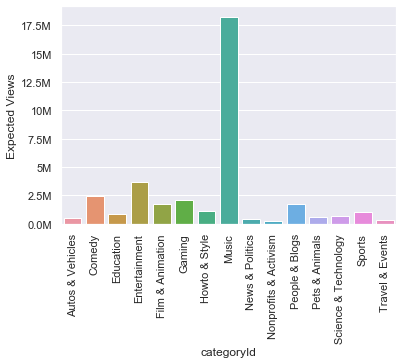

In [130]:
sns.set()
mean_view_category=yt_train[['viewCount','categoryId']].groupby(['categoryId'],as_index=False).mean()
mean_view_category.rename(columns={'viewCount':'Expected Views'},inplace=True)
s=sns.barplot(x='categoryId',y='Expected Views',data=mean_view_category)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
s.set_yticklabels(['0.0M','2.5M','5M','7.5M','10M','12.5M','15M','17.5M'])
plt.show()


In general,Music is the most watched category on Youtube followed by Entertainment,Comedy and Gaming.

Though YouTube wasn’t created to be a streaming music service, the Google-owned platform remains the single most-used website in the world to listen to music legally. While competitors like Spotify and Apple Music are growing by leaps and bounds, the majority of music lovers all around the world still prefer to head to YouTube to hear their favorites

Every year, the IFPI (the International Federation of the Phonographic Industry) publishes its Music Consumer Insight Report, which analyzes how millions of people in the world interact and access music.According to the 2017 report, video takes up 55% of all time dedicated to on-demand streaming. Incredibly, YouTube is responsible for 46% of all on-demand streaming time.

### How does Day Uploaded affect Views?


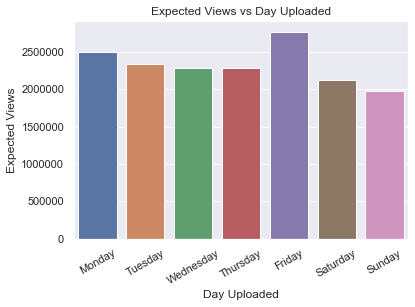

In [332]:
mean_view_by_day=yt_train[['viewCount','day_uploaded']].groupby('day_uploaded').mean()
mean_view_by_day.rename(columns={'viewCount':'Expected Views'},inplace=True)
mean_view_by_day['day']=['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']
mean_view_by_day.set_index('day',inplace=True)
reorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mean_view_by_day=mean_view_by_day.reindex(labels=reorder)
mean_view_by_day['Day Uploaded']=reorder
s=sns.barplot(data=mean_view_by_day,x='Day Uploaded',y='Expected Views')
plt.title('Expected Views vs Day Uploaded')
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.show()

In [352]:
music['day_uploaded'].value_counts()

Friday       3747
Tuesday      3567
Monday       3313
Thursday     3235
Wednesday    3229
Saturday     1582
Sunday       1447
Name: day_uploaded, dtype: int64

Since music videos tend to get most of their views during first 24 hours,and most music videos are uploaded on Friday ,therefore average views on the platform on Friday are more.

Similar tactics are often used by movie studios and TV networks that fight for record-breaking numbers and we see same pattern of uploads for entertainment.

In [365]:
entertainment=yt_train[yt_train['categoryId']=='Entertainment']
entertainment['day_uploaded'].value_counts()

Friday       3617
Thursday     3417
Wednesday    3378
Tuesday      3217
Monday       3138
Saturday     2299
Sunday       2004
Name: day_uploaded, dtype: int64

Clearly,there is a difference between number of uploads on Friday than any other day,just like for music.

To prove that this is only true for these kinds of categories and not generalized,we take example of Gaming which is more user based.

In [366]:
gaming['day_uploaded'].value_counts()

Tuesday      3329
Friday       3309
Thursday     3307
Saturday     3214
Wednesday    3086
Monday       2905
Sunday       2821
Name: day_uploaded, dtype: int64

As expected ,Friday is not the day for the most uploads and there is not much difference in number of uploads among Tuesday,Thursday and Friday.

In [349]:
mean_view_day_category=yt_train[['viewCount','categoryId','day_uploaded']].groupby(['day_uploaded','categoryId'],as_index=False).mean()
somedays=mean_view_day_category[mean_view_day_category['day_uploaded'].isin(['Monday','Friday','Saturday','Sunday'])]
somedays.rename(columns={'day_uploaded':'Day Uploaded','categoryId':'Categories','viewCount':'Total Views'},inplace=True)

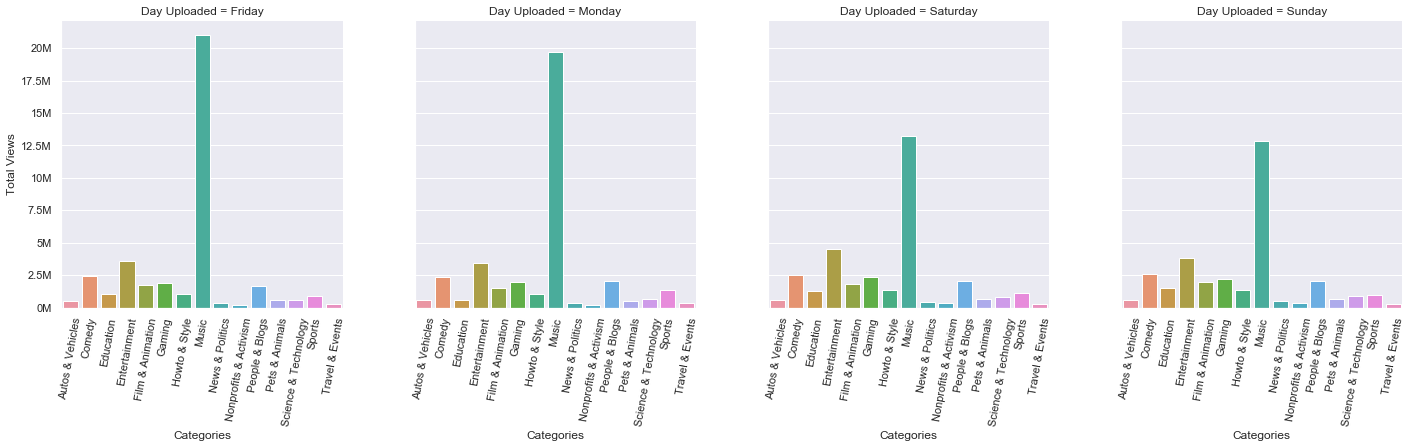

In [350]:
s=sns.catplot(data=somedays,x='Categories',y='Total Views',col='Day Uploaded',col_wrap=4,aspect=1,height=5,kind='bar',margin_titles=True,sharex=False,sharey=True)
s=s.set_xticklabels(rotation=80)
s.set_yticklabels(['0M','2.5M','5M','7.5M','10M','12.5M','15M','17.5M','20M'])
plt.show()

We saw that in general,fewer videos of all categories are uploaded on weekends.Then why is that average views for music videos are affected the most? 

Apart from organic views,running music videos as advertisements in front of other YouTube videos has become common practice within the music industry since it can be counted as a view if it’s watched for a long enough amount of time.
Keeping this in mind,calculated advertising campaigns are launched specifically to land a music video on YouTube’s charts during the first 24 hours of being published.
People use these stats — many often touting record-breaking 24-hour views — as a "definitive representation of its instant cultural impact".
Now since all other categories upload less during weekends,launching a single day advertising campaign on weekends won't make sense because in general,there are less viewers and fewer new uploads on the platform.

Sep 13-YouTube is changing how it counts views for record-breaking music videos after controversy with Baadshah beating BTS in a single day because he bought paid advertisements that embedded his music video artificially inflating the view count.

### How Does Duration Affect Views?


In [251]:
yt_train['duration'].describe()

count    312821.000000
mean        494.238744
std         807.077205
min           3.000000
25%         184.000000
50%         281.000000
75%         515.000000
max       86401.000000
Name: duration, dtype: float64

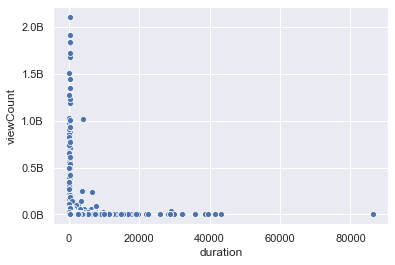

Correlation Coefficient: -0.021392297260071795


In [345]:
s=sns.scatterplot(x='duration',y='viewCount',data=yt_train)
s.set_yticklabels(['0','0.0B','0.5B','1.0B','1.5B','2.0B'])
plt.show()
print('Correlation Coefficient:',yt_train.corr()['duration']['viewCount'])

In general ,long videos get less views.Let's zoom in on the extreme left to observe the phenomenon closely.

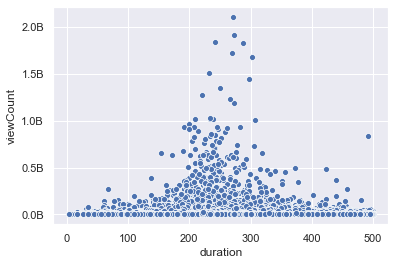

In [346]:
change=yt_train[yt_train['duration']<=500]
s=sns.scatterplot(x='duration',y='viewCount',data=change)
s.set_yticklabels(['0','0.0B','0.5B','1.0B','1.5B','2.0B'])
plt.show()

Notice that between 200 and 300 seconds,the view count spikes.

Observation: People watching Youtube prefer shorter videos(around 3.5-5minutes long)

In [300]:
top5_viewed=yt_train[['viewCount','duration']].sort_values(by='viewCount',ascending=False).head(5)
top5_viewed

,viewCount,duration
55829,2110166091,271.0
55382,1917296119,273.0
53250,1835789865,242.0
56491,1834168885,287.0
69458,1725812954,270.0


We see that top 5 most viewed videos are around 4.5 minutes long.

Since music is the most watched category ,is there a relation between music videos duration and view count?

In [324]:
music['duration'].describe()

count    20120.000000
mean       299.726044
std        546.720270
min         22.000000
25%        208.000000
50%        240.000000
75%        282.000000
max      41401.000000
Name: duration, dtype: float64

Average duration of a music video is 5 minutes and 75% of music videos are less than 5 minutes long.Now since people prefer shorter videos,that may be a reason why music is the most watched category on Youtube.